## **HW3 - Series temporales: StackOverFlow**
## Álvaro Payo Bastante

In [3]:
import warnings
warnings.filterwarnings('ignore')

## **1. Importar librerías y datos**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.models import Theta, FourTheta
from darts.models import TBATS
from darts.metrics import mape
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode

import sktime
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.transformations.series.boxcox import LogTransformer
from sktime.utils.plotting import plot_correlations


In [5]:
#Importamos la libreria de gráficos Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Análisis predictivo/StackOverflow.csv')

In [8]:
df_matlab = pd.DataFrame()

df_matlab['Fecha'] = pd.date_range(start='1/1/2009', end='31/12/2019', freq = 'M')
df_matlab['matlab'] = df['matlab']
df_matlab['Fecha'] = pd.to_datetime(df_matlab['Fecha'])
df_matlab = df_matlab.set_index('Fecha')

df_matlab.head()

,matlab
Fecha,
2009-01-31,19
2009-02-28,27
2009-03-31,24
2009-04-30,32
2009-05-31,42


In [9]:
df_matlab.index = pd.PeriodIndex(df_matlab.index, freq="M")

In [10]:
#No hay NA's
df_matlab.isnull().sum()

matlab    0
dtype: int64

Tras cargar los datos, me creo un DataFrame en el que incluyo los meses desde enero de 2009 hasta diciembre de 2019, y la columna que contiene las consultas de matlab.

Por último, la columna de fecha la pongo como índice y me aseguro de que no hay NA's. 

## **2. División en train y test**

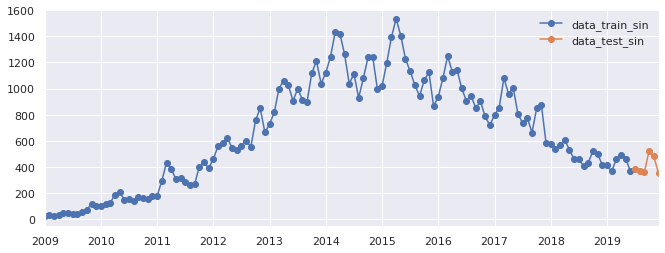

In [81]:
data_train = df_matlab['2009-01':'2019-06']
data_test = df_matlab['2019-07':'2019-12']

#Plot data 
data_train['matlab'].plot(legend=True,label='data_train_sin',marker='o')
data_test['matlab'].plot(legend=True,label='data_test_sin',figsize=(11,4),marker='o');

Divido la muestra en train y test. Train contiene las consultas desde 2009-01 hasta 2019-06, y test desde 2019-07 hasta 2019-12.

## **3. ETS**

Text(0.5, 1.0, 'Comportamiento Estacional')

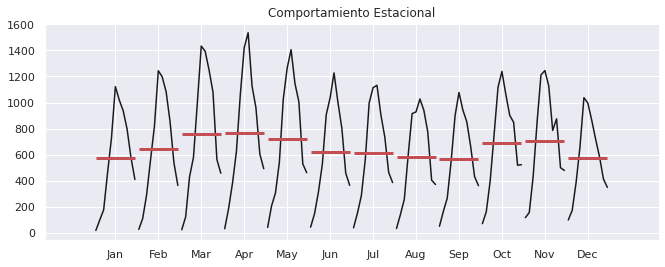

In [14]:
ax = plt.gca()
sm.graphics.tsa.month_plot(df_matlab, ax = ax)
ax.set_title('Comportamiento Estacional')

In [15]:
fh = np.arange(1, 7)

autoETS_model = AutoETS(auto = True, sp = 12, n_jobs = -1)

In [16]:
#Auto ETS Model Estimation
autoETS_model.fit(data_train)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [17]:
#Auto ETS Model Summary
print(autoETS_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  126
Model:                       ETS(MAM)   Log Likelihood                -690.953
Date:                Sun, 27 Nov 2022   AIC                           1417.907
Time:                        16:25:43   BIC                           1468.960
Sample:                    01-31-2009   HQIC                          1438.648
                         - 06-30-2019   Scale                            0.015
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.107      9.376      0.000       0.791       1.209
smoothing_trend         0.0182      0.022      0.834      0.404      -0.025       0.061
smoothing_season

In [18]:
#Auto ETS Forecasting
ETS_pred = autoETS_model.predict(fh)
ETS_pred

,matlab
2019-07,344.539077
2019-08,311.381022
2019-09,313.153998
2019-10,371.188751
2019-11,388.067150
2019-12,316.343059


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

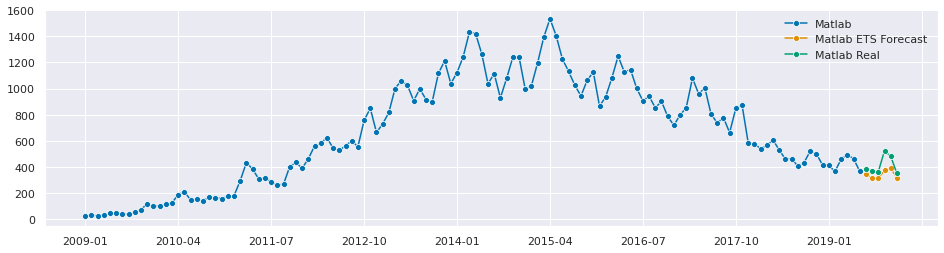

In [20]:
plot_series(data_train, ETS_pred, data_test, labels=["Matlab", "Matlab ETS Forecast", "Matlab Real"])

In [19]:
df_matlab_ints = autoETS_model.predict_interval(fh, coverage=0.9)
df_matlab_ints

Coverage            
                0.9            
              lower       upper
2019-07  270.748903  416.535982
2019-08  222.989373  405.499276
2019-09  207.586540  431.084895
2019-10  224.868792  531.952444
2019-11  219.640232  597.624671
2019-12  169.733348  517.003629

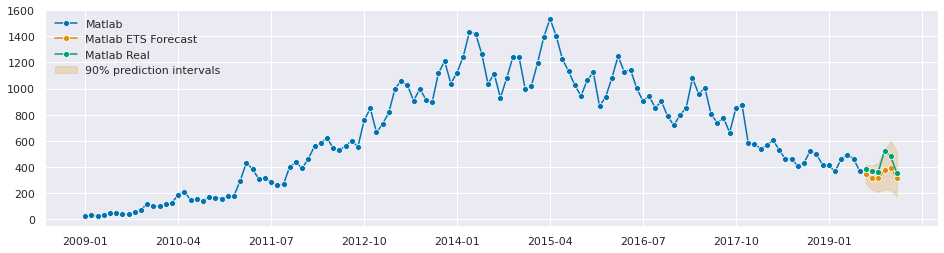

In [21]:
fig, ax = plot_series(data_train, ETS_pred, data_test, labels=["Matlab", "Matlab ETS Forecast", "Matlab Real"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    df_matlab_ints[('Coverage', 0.9, 'lower')],
    df_matlab_ints[('Coverage', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')

In [75]:
#1. Mean Absolute Percentage Error (MAPE)
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

MAPE_ETS = mean_absolute_percentage_error(data_test, ETS_pred[0:6])*100
MAPE_ETS

16.278756408015795

In [83]:
#2. Mean Squared Error (MSE)
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError() 
MSE_ETS = mse(data_test, ETS_pred[0:6])
MSE_ETS

6673.546147936121

In [82]:
#3. Root Mean Square Error (RMSE)
rmse = MeanSquaredError(square_root=True)
RMSE_ETS = rmse(data_test, ETS_pred[0:6])
RMSE_ETS

81.69177527717292

Estimo el modelo ETS y realizo las predicciones sobre test. Se puede ver como **las predicciones están por debajo de las consultas reales** que se han realizado sobre matlab, aunque se encuentran dentro del intervalo de confianza al 90%. 

Las mayores diferencias entre las predicciones y los datos reales se producen en octubre y en noviembre.

Además, **el MAPE está en torno al 16**%, siendo un porcentaje de error aceptable.

## **4. ARIMA**

In [25]:
#Transformación de los datos a logaritmos.
transformer = LogTransformer()
log_df_matlab = transformer.fit_transform(df_matlab)
log_df_matlab.tail()

,matlab
Fecha,
2019-08,5.916202
2019-09,5.891644
2019-10,6.259581
2019-11,6.171701
2019-12,5.855072


Text(0.5, 1.0, 'Consultas Matlab: Transformación LOG')

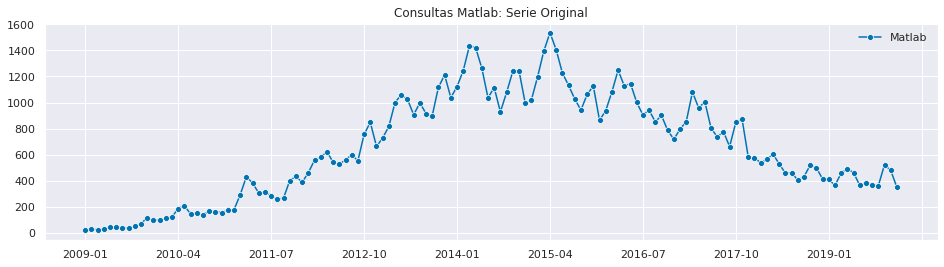

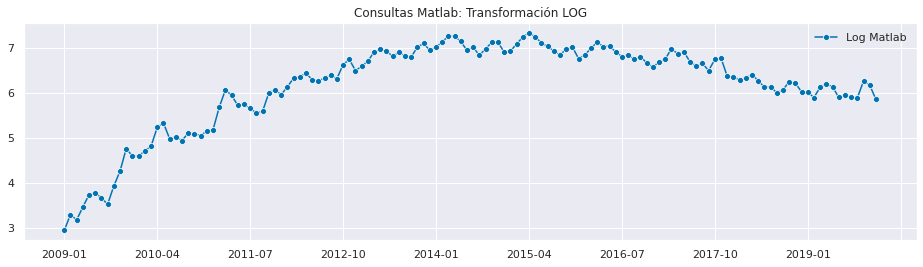

In [26]:
#Comparación gráfico con datos originales vs gráfico con datos transformados a logaritmos.
fig, ax = plot_series(df_matlab, labels = ["Matlab"])
ax.set_title('Consultas Matlab: Serie Original')
fig, ax = plot_series(log_df_matlab, labels = ["Log Matlab"])
ax.set_title('Consultas Matlab: Transformación LOG')

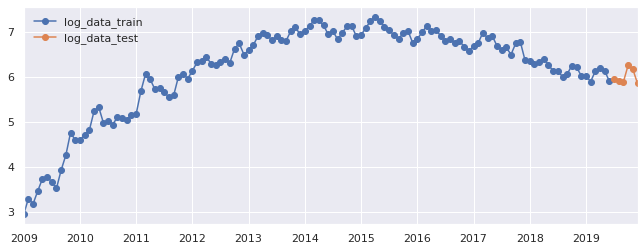

In [27]:
#log train desde 2009-01 hasta 2019-06
#log test desde 2019-07 hasta 2019-12

log_data_train = log_df_matlab['2009-01':'2019-06']
log_data_test = log_df_matlab['2019-07':'2019-12']

#Plot data 
log_data_train['matlab'].plot(legend=True,label='log_data_train',marker='o')
log_data_test['matlab'].plot(legend=True,label='log_data_test',marker='o');

In [28]:
fh2 = np.arange(1, 7) 

ARIMA_model = AutoARIMA(sp = 12,suppress_warnings = True)

In [29]:
ARIMA_model.fit(log_data_train)

AutoARIMA(sp=12, suppress_warnings=True)

In [30]:
print(ARIMA_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  126
Model:             SARIMAX(4, 2, 1)x(1, 0, 1, 12)   Log Likelihood                  71.666
Date:                            Sun, 27 Nov 2022   AIC                           -127.332
Time:                                    16:30:40   BIC                           -104.770
Sample:                                01-31-2009   HQIC                          -118.167
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1666      0.088     -1.904      0.057      -0.338       0.005
ar.L2         -0.2628      0.077   

In [31]:
log_data_pred = ARIMA_model.predict(fh2)
log_data_pred

,matlab
2019-07,5.795640
2019-08,5.712010
2019-09,5.684548
2019-10,5.813455
2019-11,5.786271
2019-12,5.563554


In [32]:
np.exp(log_data_pred)

,matlab
2019-07,328.862679
2019-08,302.478543
2019-09,294.284706
2019-10,334.773751
2019-11,325.796010
2019-12,260.747784


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

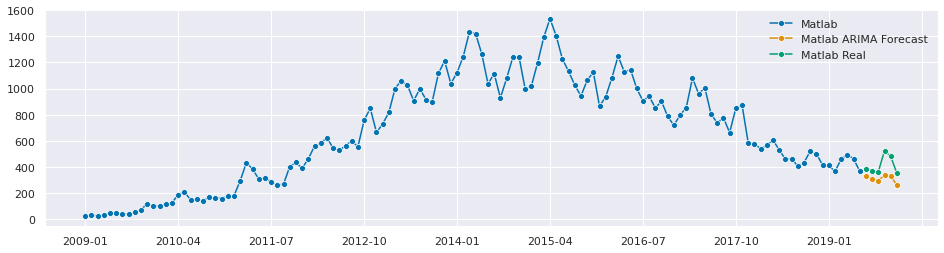

In [35]:
plot_series(data_train, np.exp(log_data_pred), data_test, labels=["Matlab", "Matlab ARIMA Forecast", "Matlab Real"])

In [33]:
df_matlab_ints2 = ARIMA_model.predict_interval(fh2, coverage=0.9)
df_matlab_ints2

Coverage          
              0.9          
            lower     upper
2019-07  5.583254  6.008027
2019-08  5.426974  5.997047
2019-09  5.361947  6.007149
2019-10  5.461640  6.165270
2019-11  5.413590  6.158953
2019-12  5.160610  5.966497

In [34]:
np.exp(df_matlab_ints2)

Coverage            
                0.9            
              lower       upper
2019-07  265.935432  406.680151
2019-08  227.459942  402.239041
2019-09  213.139482  406.323068
2019-10  235.483295  475.929575
2019-11  224.435893  472.932556
2019-12  174.270713  390.136733

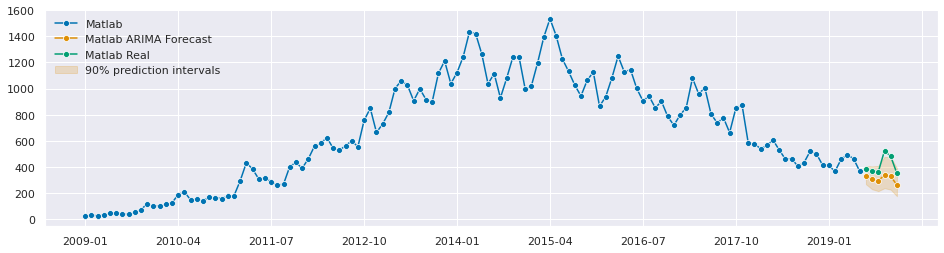

In [36]:
fig, ax = plot_series(data_train, np.exp(log_data_pred), data_test, labels=["Matlab", "Matlab ARIMA Forecast", "Matlab Real"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    np.exp(df_matlab_ints2)[('Coverage', 0.9, 'lower')],
    np.exp(df_matlab_ints2)[('Coverage', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')

In [88]:
#1a. Mean Absolute Percentage Error (MAPE)
MAPElog_ARIMA = mean_absolute_percentage_error(log_data_test, log_data_pred)
MAPElog_ARIMA

0.9857915096050354

In [76]:
#1b. Mean Absolute Percentage Error (MAPE) -> Original Time Serie
MAPE_ARIMA = mean_absolute_percentage_error(data_test, np.exp(log_data_pred))*100
MAPE_ARIMA

24.206452411181996

In [87]:
#2a. Mean Squared Error (MSE)
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError() 
MSElog_ARIMA = mse(log_data_test, log_data_pred)
MSElog_ARIMA 

169052.18668408997

In [86]:
#2b. Mean Squared Error (MSE) -> Original Time Serie
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError() 
MSE_ARIMA =  mse(data_test, np.exp(log_data_pred))
MSE_ARIMA

13205.710247158706

In [84]:
#3a. Root Mean Square Error (RMSE)
rmse = MeanSquaredError(square_root=True)
RMSElog_ARIMA = rmse(log_data_test, log_data_pred)
RMSElog_ARIMA

411.1595635323225

In [46]:
#3b. Root Mean Square Error (RMSE) -> Original Time Serie
rmse = MeanSquaredError(square_root=True)
RMSE_ARIMA = rmse(data_test, np.exp(log_data_pred))
RMSE_ARIMA 

114.9161009047849

Estimo el modelo ARIMA y realizo las predicciones sobre test. **Las predicciones son bastante parecidas a las del modelo ETS**, aunque son incluso más bajas que estas, por lo que **se alejan aún más de la realidad.**

**El MAPE está en torno al 24**%, siendo un porcentaje de error que ya podemos considerar bastante alto y, por lo tanto, inaceptable.

## **5. 4THETA**

In [47]:
df_matlab_series = pd.DataFrame()

df_matlab_series['Fecha'] = pd.date_range(start='1/1/2009', end='31/12/2019', freq = 'M')
df_matlab_series['matlab'] = df['matlab']
df_matlab_series['Fecha'] = pd.to_datetime(df_matlab_series['Fecha'], format = '%y-%b')

In [48]:
matlab_series = TimeSeries.from_dataframe(df_matlab_series, 'Fecha', 'matlab')
matlab_series 

<TimeSeries (DataArray) (Fecha: 132, component: 1, sample: 1)>
array([[[  19.]],

       [[  27.]],

       [[  24.]],

       [[  32.]],

       [[  42.]],

       [[  44.]],

       [[  39.]],

       [[  34.]],

       [[  51.]],

       [[  71.]],

...

       [[ 458.]],

       [[ 492.]],

       [[ 462.]],

       [[ 365.]],

       [[ 386.]],

       [[ 371.]],

       [[ 362.]],

       [[ 523.]],

       [[ 479.]],

       [[ 349.]]])
Coordinates:
  * Fecha      (Fecha) datetime64[ns] 2009-01-31 2009-02-28 ... 2019-12-31
  * component  (component) object 'matlab'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Para poder implementar este modelo, **es necesario transformar el DataFrame a una serie. **

Para ello, el DataFrame debe tener la fecha como columna en vez de como índice, por lo que me creo un nuevo DataFrame en el que incluyo la fecha como columna, y más tarde, lo convierto a serie.

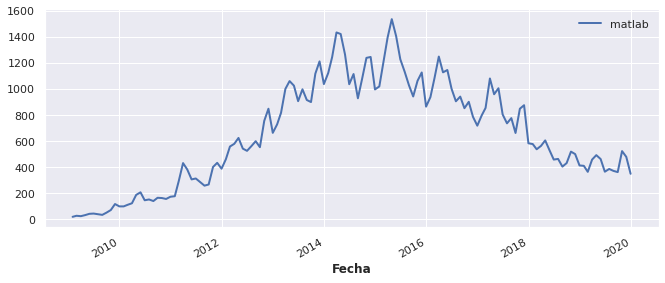

In [49]:
plt.rcParams["figure.figsize"] = (11,4)
matlab_series.plot()

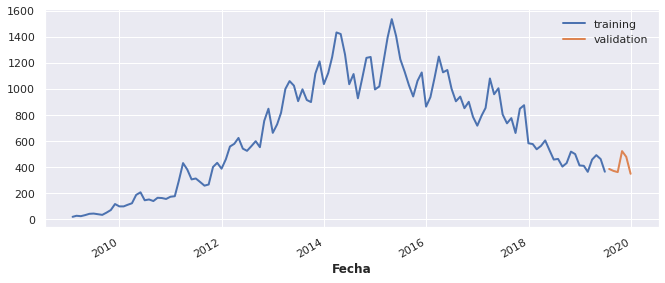

In [50]:
train_series, val_series = matlab_series.split_before(pd.Timestamp("20190731"))
train_series.plot(label="training")
val_series.plot(label="validation")

In [51]:
four_theta_model = FourTheta(seasonality_period = 12)
four_theta_model.fit(train_series)
forecast_four_theta = four_theta_model.predict(len(val_series))
print("model {} obtains MAPE: {:.2f}%".format(four_theta_model, mape(val_series, forecast_four_theta)))

model 4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE) obtains MAPE: 41.07%


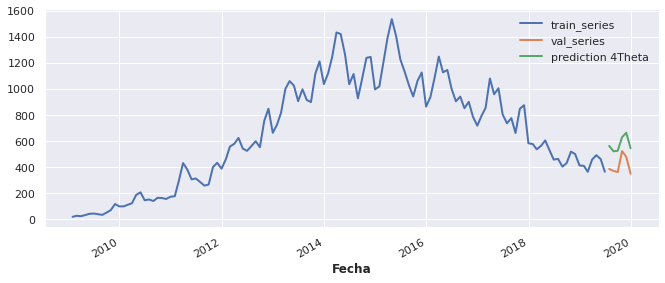

In [52]:
train_series.plot(label = "train_series")
val_series.plot(label = "val_series")
forecast_four_theta.plot(label = "prediction 4Theta")

Estimo el modelo y me sale muy errático, como se puede apreciar tanto en el MAPE obtenido como en el gráfico. 

Para mejorar las predicciones, tuneo los hiperparámetros para usar los que mejor van a estimar el modelo.

In [53]:
theta_grid = {
    #'theta':2- np.linspace(-10, 10, 10),
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model = FourTheta.gridsearch(parameters = theta_grid,
                                series = train_series,
                                forecast_horizon = 6, # 12
                                start = 0.5,
                                last_points_only = False,
                                metric = mape,
                                reduction = np.mean,
                                verbose = False,
                                n_jobs = -1)

best_grid_model

(<darts.models.forecasting.theta.FourTheta at 0x7f820a2686d0>,
 {'theta': 1,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 18.901827437056177)

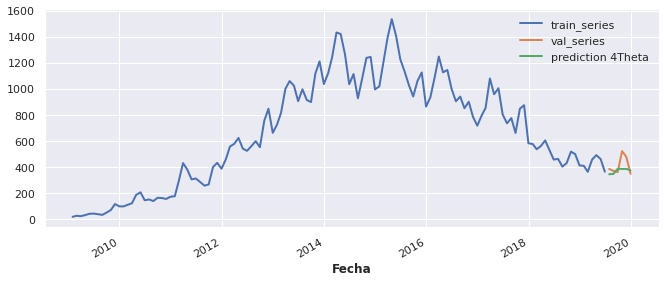

In [54]:
modelo1 = FourTheta(theta = best_grid_model[1]['theta'],
                 model_mode = ModelMode.ADDITIVE,
                 season_mode = SeasonalityMode.ADDITIVE,
                 trend_mode = TrendMode.EXPONENTIAL
                 )
modelo1.fit(train_series)
pred_modelo = modelo1.predict(len(val_series))

train_series.plot(label = "train_series")
val_series.plot(label = "val_series")
pred_modelo.plot(label = "prediction 4Theta")

In [56]:
#MAPE
MAPE_4THETA = mape(val_series, pred_modelo)
MAPE_4THETA 

12.717845843303307

Una vez cambiados algunos de los hiperparámetros, estimo el modelo de nuevo y este mejora las predicciones anteriores considerablemente. 

Aunque **las predicciones** son más bajas que los datos reales, igual que en los dos modelos que he estimado antes, estas **se acercan más a la realidad que los otros modelos y el MAPE es más bajo, situándose cerca del 13%.**

## **6. TBATS**

In [67]:
matlab_series 

<TimeSeries (DataArray) (Fecha: 132, component: 1, sample: 1)>
array([[[  19.]],

       [[  27.]],

       [[  24.]],

       [[  32.]],

       [[  42.]],

       [[  44.]],

       [[  39.]],

       [[  34.]],

       [[  51.]],

       [[  71.]],

...

       [[ 458.]],

       [[ 492.]],

       [[ 462.]],

       [[ 365.]],

       [[ 386.]],

       [[ 371.]],

       [[ 362.]],

       [[ 523.]],

       [[ 479.]],

       [[ 349.]]])
Coordinates:
  * Fecha      (Fecha) datetime64[ns] 2009-01-31 2009-02-28 ... 2019-12-31
  * component  (component) object 'matlab'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

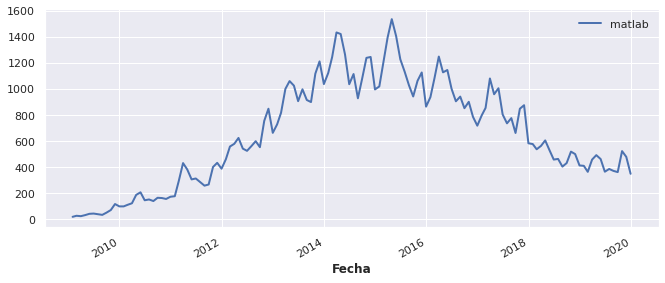

In [68]:
plt.rcParams["figure.figsize"] = (11,4)
matlab_series.plot()

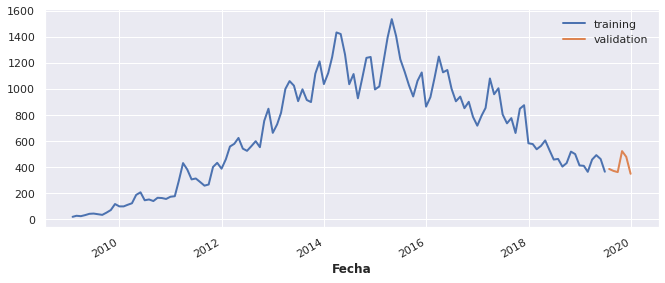

In [69]:
train_series.plot(label="training")
val_series.plot(label="validation")

In [70]:
model_TBATS = TBATS(
use_box_cox = None,
box_cox_bounds = (0, 1),
use_trend = None,
use_damped_trend = None,
seasonal_periods = "freq",
use_arma_errors = True,
show_warnings = False,
multiprocessing_start_method = 'spawn',
random_state = 0)
model_TBATS.fit(train_series)
forecast_TBATS = model_TBATS.predict(len(val_series))
print("model {} obtains MAPE: {:.2f}%".format(model_TBATS, mape(val_series, forecast_TBATS)))

model (T)BATS obtains MAPE: 23.31%


In [71]:
model_TBATS.model.params.summary()

'Use Box-Cox: True\nUse trend: True\nUse damped trend: False\nSeasonal periods: [12.]\nSeasonal harmonics [4]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 0.575624\nSmoothing (Alpha): 0.731800\nTrend (Beta): 0.041770\nDamping Parameter (Phi): 1.000000\nSeasonal Parameters (Gamma): [ 1.31516020e-07 -3.15248939e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [ 3.62023513  1.87152987  1.10672604 -4.22303091 -1.89909995  0.80224378\n  4.20342617 -0.51672321  0.67266762  1.30258307]\n'

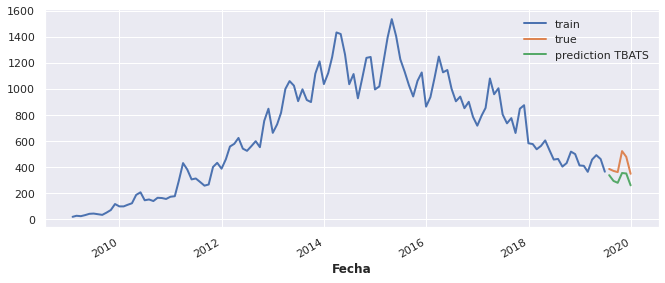

In [72]:
train_series.plot(label="train")
val_series.plot(label="true")
forecast_TBATS.plot(label="prediction TBATS")

In [73]:
#MAPE
MAPE_TBATS = mape(val_series, forecast_TBATS)
MAPE_TBATS

23.307091816401375

Estimo el último modelo (TBATS) y obtengo unas **predicciones por debajo de los datos reales en todo momento** y un** MAPE cercano al 23%**, por lo que es un modelo bastante errático y alejado de la realidad.

## **7. Predicción de 12 meses fuera de la muestra**


In [78]:
MAPE_modelos = pd.DataFrame()

MAPE_modelos['Modelos'] = ["ETS", "ARIMA", "4THETA", "TBATS"]
MAPE_modelos['MAPE (%)'] = [MAPE_ETS, MAPE_ARIMA, MAPE_4THETA, MAPE_TBATS]
MAPE_modelos.set_index('Modelos', inplace = True)
MAPE_modelos = MAPE_modelos.sort_values(by = "MAPE (%)", ascending = True)

MAPE_modelos.round(3)

,MAPE (%)
Modelos,
4THETA,12.718
ETS,16.279
TBATS,23.307
ARIMA,24.206


Se puede ver como tras estimar los cuatro modelos, **el que obtiene un menor MAPE es el 4Theta**, por lo tanto es el mejor modelo de los 
cuatro ya que tiene un menor error.

Tras seleccionar cual es el mejor modelo, procedo a realizar una predicción de 12 meses fuera de la muestra sobre ese modelo, 
en este caso, el modelo 4Theta.



In [94]:
theta_grid2 = {
    #'theta':2- np.linspace(-10, 10, 10),
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model2 = FourTheta.gridsearch(parameters = theta_grid2,
                                series = matlab_series,
                                forecast_horizon = 12,
                                start = 0.5,
                                last_points_only = False,
                                metric = mape,
                                reduction = np.mean,
                                verbose = False,
                                n_jobs = -1) 

best_grid_model2

(<darts.models.forecasting.theta.FourTheta at 0x7f82084bad90>,
 {'theta': 1,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 23.026167702147593)

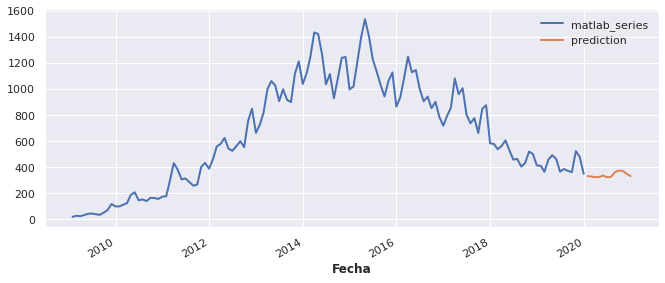

In [95]:
modelo3 = FourTheta(theta = best_grid_model[1]['theta'],
                 model_mode = ModelMode.ADDITIVE,
                 season_mode = SeasonalityMode.ADDITIVE,
                 trend_mode = TrendMode.EXPONENTIAL
                 )
modelo3.fit(matlab_series)
pred_modelo2 = modelo3.predict(12)

matlab_series.plot(label = "matlab_series")
pred_modelo2.plot(label = "prediction")

In [96]:
pred_modelo2

<TimeSeries (DataArray) (Fecha: 12, component: 1, sample: 1)>
array([[[331.27803191]],

       [[327.92465725]],

       [[323.26825229]],

       [[323.85427158]],

       [[335.50847268]],

       [[322.52321097]],

       [[325.60454706]],

       [[361.37954706]],

       [[373.62424403]],

       [[371.32348645]],

       [[349.0000016 ]],

       [[331.27803191]]])
Coordinates:
  * Fecha      (Fecha) datetime64[ns] 2020-01-31 2020-02-29 ... 2020-12-31
  * component  (component) object 'matlab'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Tras ver cuales son los hiperparámetros adecuados y estimar el modelo 4Theta para los próximos 12 meses fuera de la muestra, **obtengo una predicción que sigue siendo bastante baja.**

Por lo visto en las estimaciones anteriores sobre test, **las predicciones seguramente se encuentren por debajo de las consultas reales sobre matlab.**